# №17. Трансферное обучение (Transfer learning)

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms, datasets
import torchvision.models as models

from tqdm import tqdm

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 1. Загрузка данных

### 1.1 Загрузка и распаковка zip-архива с данными

In [4]:
import requests
import os
import zipfile

DATA_URL = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
DATA_PATH = os.path.join('.', 'data')
FILE_NAME = os.path.join(DATA_PATH, 'hymenoptera_data.zip')

if not os.path.isfile(FILE_NAME):
    print("Downloading the data...")
    os.makedirs('data', exist_ok=True)
    with requests.get(DATA_URL) as req:
        with open(FILE_NAME, 'wb') as f:
            f.write(req.content)
    if 200 <= req.status_code < 300:
        print("Download complete!")
    else:
        print("Download failed!")
else:
    print(FILE_NAME, "already exists, skipping download...")

with zipfile.ZipFile(FILE_NAME, 'r') as zip_ref:
    print("Unzipping...")
    zip_ref.extractall('data')

DATA_PATH = os.path.join(DATA_PATH, 'hymenoptera_data')
print("", DATA_PATH)

.\data\hymenoptera_data.zip already exists, skipping download...
Unzipping...
 .\data\hymenoptera_data


### 1.2 Предобработка данных

In [5]:
transforms_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
train_data = datasets.ImageFolder("./data/hymenoptera_data/train", transform=transforms_train)
val_data = datasets.ImageFolder("./data/hymenoptera_data/val", transform=transforms_val)
len(train_data), len(val_data)

(244, 153)

In [7]:
class_names = train_data.classes
class_names

['ants', 'bees']

In [8]:
BATCH_SIZE = 16
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

## 2. Обучение моделей

In [79]:
import numpy as np
import random
import matplotlib.pyplot as plt

### 2.0 Вспомогательные функции

In [ ]:
def plot_training_curves(train_loss, val_loss, train_acc, val_acc, lr_list):
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].plot(train_loss, label="Train Loss")
    axes[0].plot(val_loss, label="Validation Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Loss Curve")
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(train_acc, label="Train Accuracy")
    axes[1].plot(val_acc, label="Validation Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Accuracy Curve")
    axes[1].legend()
    axes[1].grid(True)

    axes[2].plot(lr_list, label="LR Rate")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Learning Rate")
    axes[2].set_title("Learning Rate Curve")
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

In [48]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    n_epochs: int,
    opt: torch.optim.Optimizer,
    loss_model: nn.Module,
    lr_scheduler: torch.optim.lr_scheduler.LRScheduler
    ):
    
    EPOCHS = n_epochs
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    lr_list = []

    # Цикл обучения
    for epoch in range(EPOCHS):
        
        # Обучение модели
        model.train()
        running_train_loss = []
        true_answer = 0
        train_loop = tqdm(train_loader, leave=False)
        
        for x, targets in train_loop:
            # Обработка данных
            targets = targets.reshape(-1).to(torch.int32)
            targets = torch.eye(2)[targets].to(device)
            
            # Прямой проход и расчет ошибки модели
            pred = model(x)
            loss = loss_model(pred, targets)
            
            # Обратный проход
            opt.zero_grad() # обнуляем предыдущие градиенты
            loss.backward() # вычисялем новые градиенты
            opt.step()      # применяем шаг оптимизации
            
            running_train_loss.append(loss.item())
            mean_train_loss = sum(running_train_loss)/len(running_train_loss)
            
            true_answer += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()
            
            desc = f"Epoch [{epoch+1}/{EPOCHS}], {mean_train_loss=:.4f}"
            train_loop.set_description(desc)
            
        # Расчет значения точности после эпохи обучения
        running_train_acc = true_answer / len(train_data)
        
        # Сохранение значений функции потерь и точности
        train_loss.append(mean_train_loss)
        train_acc.append(running_train_acc)
        
        # Валидация модели
        model.eval()
        with torch.no_grad():
            running_val_loss = []
            true_answer = 0
            for x, targets in val_loader:
                # Обработка данных
                targets = targets.reshape(-1).to(torch.int32)
                targets = torch.eye(2)[targets].to(device)
                
                # Прямой проход и расчет ошибки модели
                pred = model(x)
                loss = loss_model(pred, targets)
        
                running_val_loss.append(loss.item())
                mean_val_loss = sum(running_val_loss)/len(running_val_loss)
                
                true_answer += (pred.argmax(dim=1) == targets.argmax(dim=1)).sum().item()
        
        # Расчет точности    
        running_val_acc = true_answer / len(val_data)
        
        # Сохранение значений функции потерь и точности
        val_loss.append(mean_val_loss)
        val_acc.append(running_val_acc)
        
        lr_scheduler.step(mean_val_loss)
        lr = lr_scheduler.get_last_lr()[0]
        lr_list.append(lr)
        
        info = "Epoch [{}/{}], train_loss={:.4f}, train_acc={:.4f}, val_loss={:.4f}, val_acc={:4f}, lr={}" \
        .format(epoch+1, EPOCHS, mean_train_loss, running_train_acc, mean_val_loss, running_val_acc, lr)
        
        print(info)
        
    plot_training_curves(
        train_loss=train_loss,
        val_loss=val_loss,
        train_acc=train_acc,
        val_acc=val_acc,
        lr_list=lr_list
    )

### 2.1 Обучение с нуля (без Transfer Learning)

#### Вариант 1
- Модель НЕ обучена
- Меняем только послдений слой у VGG

In [49]:
model = models.vgg11()
model;

In [50]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [52]:
model.classifier[6] = nn.Linear(in_features=4096, out_features=2)
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

In [53]:
model = model.to(device)

loss_model = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=2)

Epoch [1/5], train_loss=0.7525, train_acc=0.5082, val_loss=0.6774, val_acc=0.542484, lr=0.0001


Epoch [2/5], train_loss=0.6866, train_acc=0.5123, val_loss=0.6939, val_acc=0.509804, lr=0.0001


Epoch [3/5], train_loss=0.6346, train_acc=0.5861, val_loss=0.8935, val_acc=0.542484, lr=0.0001


Epoch [4/5], train_loss=0.6833, train_acc=0.6107, val_loss=0.6751, val_acc=0.594771, lr=0.0001


Epoch [5/5], train_loss=0.6435, train_acc=0.5656, val_loss=0.6718, val_acc=0.568627, lr=0.0001


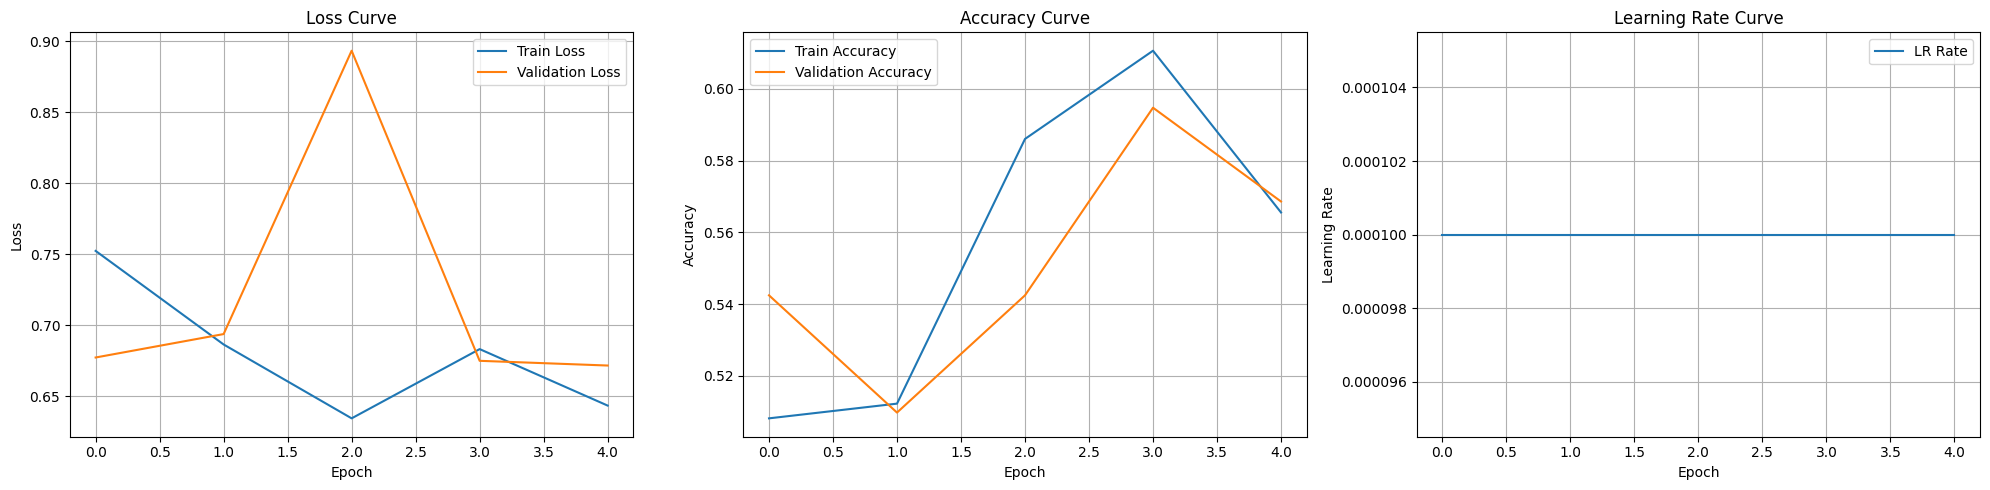

In [54]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=5,
    opt=opt,
    loss_model=loss_model,
    lr_scheduler=lr_scheduler
)

**Выводы:**
1. По факту модель не обучилась
2. Очень большое влияние имеет `lr`
3. Обучение занимает много времени (5 эпох за ~8 мин 30 сек)

Обучать с нуля в данном случае - плохая идея.

#### Вариант 2
- Модель НЕ обучена
- Меняем весь классификатор

In [55]:
model = models.vgg11()
model.classifier = nn.Linear(512*7*7, 2)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [56]:
model = model.to(device)

loss_model = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=2)

Epoch [1/5], train_loss=1.5635, train_acc=0.4959, val_loss=0.6792, val_acc=0.542484, lr=0.001


Epoch [2/5], train_loss=0.7035, train_acc=0.5328, val_loss=0.6999, val_acc=0.457516, lr=0.001


Epoch [3/5], train_loss=0.6944, train_acc=0.5041, val_loss=0.6973, val_acc=0.457516, lr=0.001


Epoch [4/5], train_loss=0.6946, train_acc=0.5041, val_loss=0.6958, val_acc=0.457516, lr=0.0001


Epoch [5/5], train_loss=0.6932, train_acc=0.5041, val_loss=0.6951, val_acc=0.457516, lr=0.0001


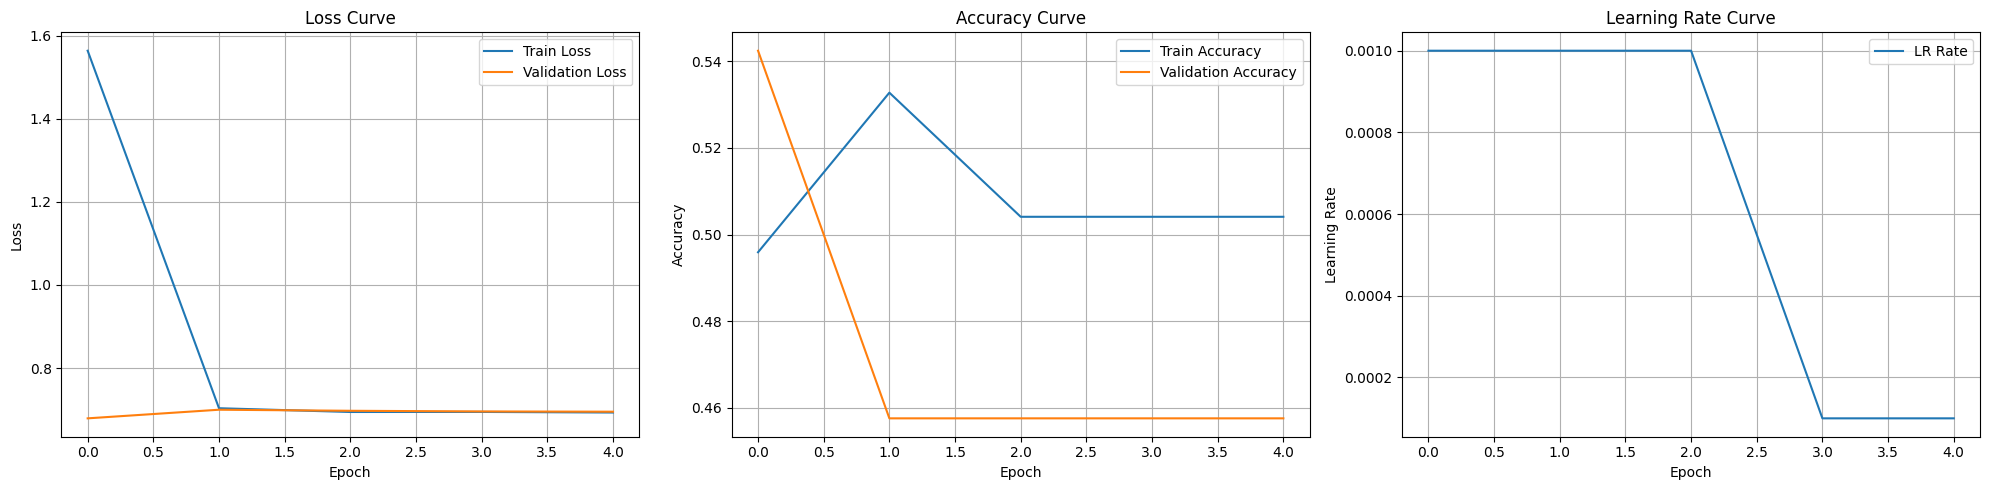

In [57]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=5,
    opt=opt,
    loss_model=loss_model,
    lr_scheduler=lr_scheduler
)

**Выводы:**
1. По факту модель не обучилась
2. Очень большое влияние имеет `lr`

Время обучения снизилось по причине замены слоя классифкатора, который имеет меньше весов, однако точность все также оставляет желать лучшего.

### 2.2 Обучение с Transfer Learning

#### Вариант 1
- Модель обучена
- НЕ замораживаем обученные параметры
- Меняем последний слой

In [60]:
model = models.vgg11(weights='DEFAULT')
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [61]:
model.classifier[6] = nn.Linear(4096, 2)
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

In [62]:
model = model.to(device)

loss_model = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=2)

Epoch [1/5], train_loss=1.5550, train_acc=0.5000, val_loss=0.8242, val_acc=0.542484, lr=0.001


Epoch [2/5], train_loss=0.7856, train_acc=0.4385, val_loss=0.6719, val_acc=0.542484, lr=0.001


Epoch [3/5], train_loss=0.7027, train_acc=0.4959, val_loss=0.6758, val_acc=0.535948, lr=0.001


Epoch [4/5], train_loss=0.7052, train_acc=0.5287, val_loss=0.6593, val_acc=0.535948, lr=0.001


Epoch [5/5], train_loss=0.7107, train_acc=0.4795, val_loss=0.6617, val_acc=0.549020, lr=0.001


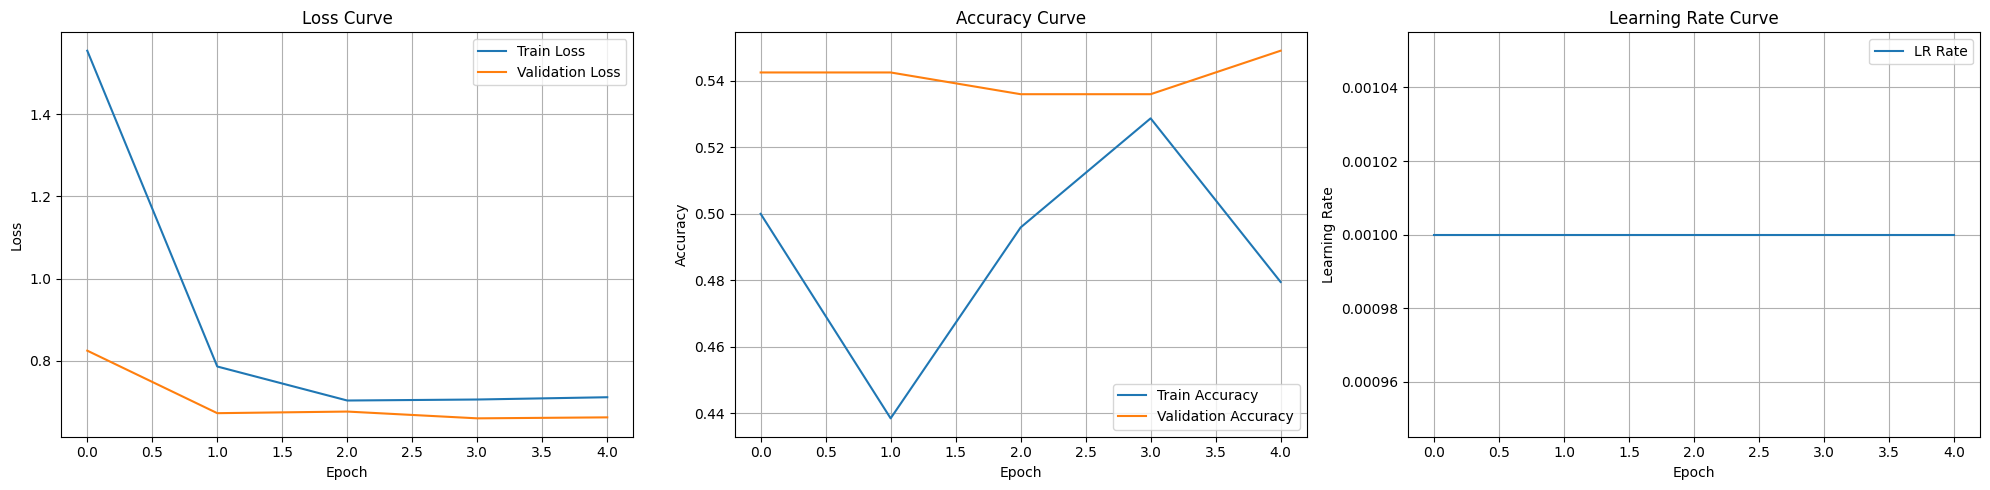

In [63]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=5,
    opt=opt,
    loss_model=loss_model,
    lr_scheduler=lr_scheduler
)

**Выводы:**
1. По факту модель не обучилась
2. Обучение занимает много времени (5 эпох за ~10 мин 50 cек)

Из-за необученности последнего слоя, получили по итогам первой эпохи большие шаги градинета, следствием этого является просадка точности на 2 эпохе. Снова модель не обучилась, времени на обучение затратили кучу. По сути только сбили обученные веса, так еще и не обучили все равно модель.    

#### Вариант 2
- Модель обучена
- НЕ замораживаем обученные параметры
- Меняем весь классификатор

In [64]:
model = models.vgg11(weights='DEFAULT')
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [65]:
model.classifier = nn.Linear(512*7*7, 2)
model.classifier

Linear(in_features=25088, out_features=2, bias=True)

In [66]:
model = model.to(device)

loss_model = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=2)

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [1/5], train_loss=2.2852, train_acc=0.5656, val_loss=4.0984, val_acc=0.457516, lr=0.001


Epoch [2/5], train_loss=0.9801, train_acc=0.5533, val_loss=0.6586, val_acc=0.549020, lr=0.001


Epoch [3/5], train_loss=0.6938, train_acc=0.5492, val_loss=0.6155, val_acc=0.699346, lr=0.001


Epoch [4/5], train_loss=0.6109, train_acc=0.6762, val_loss=0.5707, val_acc=0.718954, lr=0.001


Epoch [5/5], train_loss=0.5941, train_acc=0.6885, val_loss=0.5813, val_acc=0.673203, lr=0.001


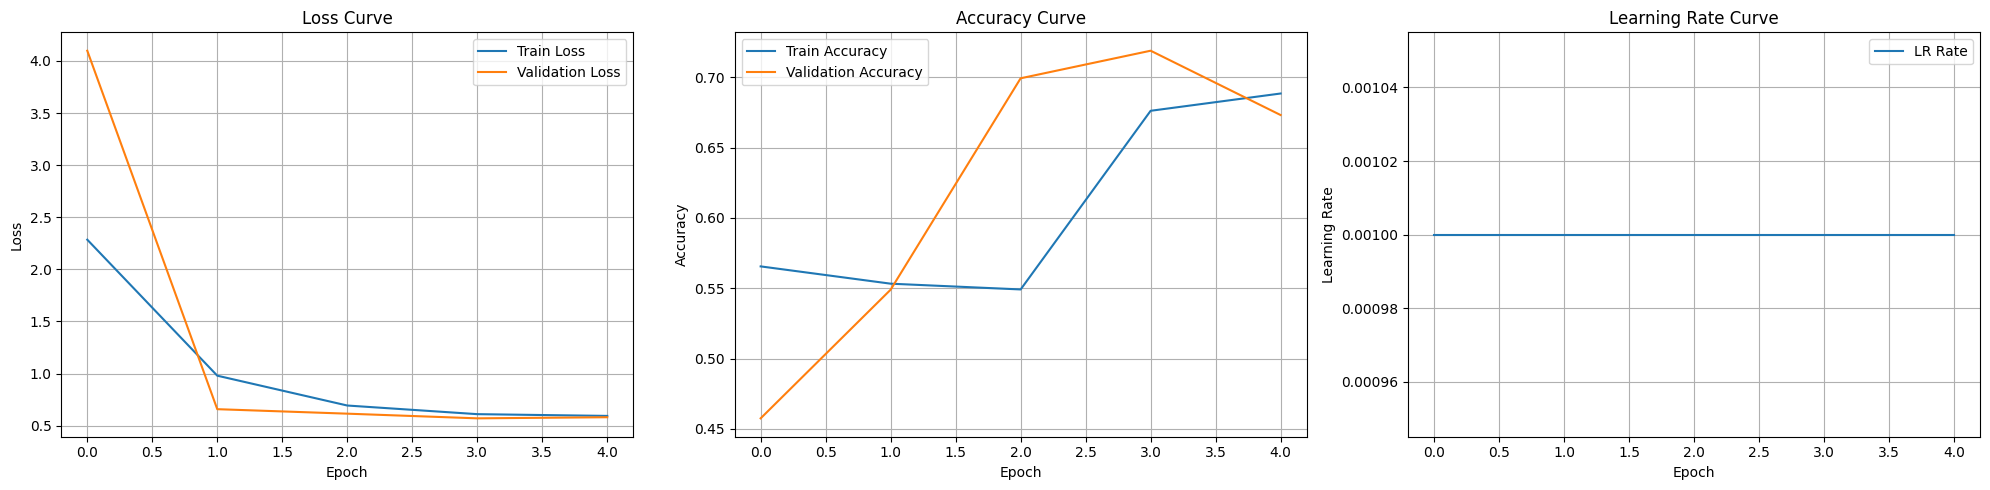

In [67]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=5,
    opt=opt,
    loss_model=loss_model,
    lr_scheduler=lr_scheduler
)

Наблюдаем стаблиьное снижение ***loss*** и повышение ***accuracy***, прогоним модель еще через 5 эпох.

Epoch [1/5], train_loss=0.5505, train_acc=0.7541, val_loss=0.5539, val_acc=0.745098, lr=0.001


Epoch [2/5], train_loss=0.5775, train_acc=0.6803, val_loss=0.7270, val_acc=0.758170, lr=0.001


Epoch [3/5], train_loss=0.5421, train_acc=0.7213, val_loss=0.7368, val_acc=0.594771, lr=0.001


Epoch [4/5], train_loss=0.5362, train_acc=0.7459, val_loss=0.6410, val_acc=0.633987, lr=0.0001


Epoch [5/5], train_loss=0.5728, train_acc=0.6762, val_loss=0.5889, val_acc=0.647059, lr=0.0001


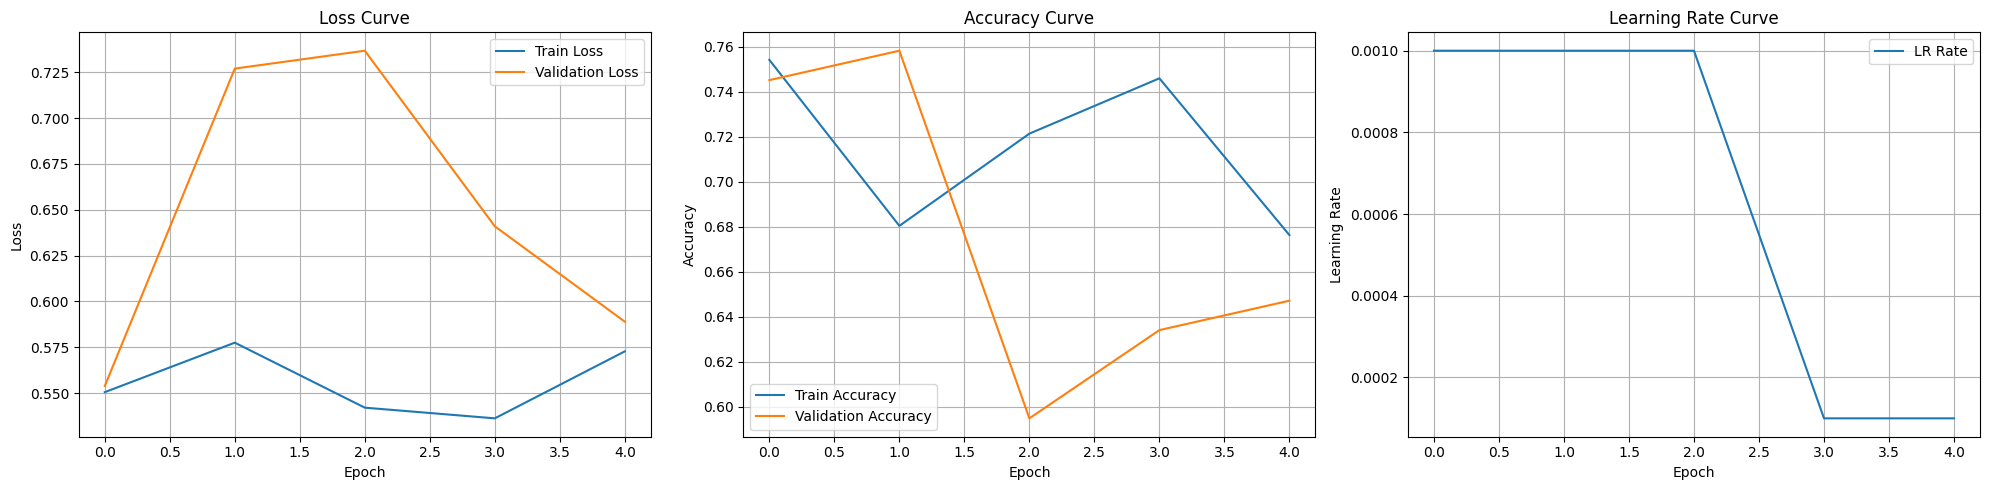

In [75]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=5,
    opt=opt,
    loss_model=loss_model,
    lr_scheduler=lr_scheduler
)

**Выводы:**
1. Досигли рекордного accuracy score в ~75% на валидационной выборке
2. Обучение относительно быстрое (5 эпох за ~5 мин 40 cек)

Данный подход имеет место быть, но требует тонкой настройки гиперпараметров, чтобы не переобучить модель, как в нашем случае.

#### Вариант 3 👑
- Модель обучена
- **Замораживаем обученные параметры**
- Меняем весь классфикатор

In [76]:
model = models.vgg11(weights='DEFAULT')

for param in model.parameters():
    param.requires_grad = False # отключаем вычисление градиентов для тензоров-весов
    
model.classifier = nn.Linear(512*7*7, 2)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [77]:
model = model.to(device)

loss_model = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5)

Epoch [1/15], train_loss=0.4753, train_acc=0.8402, val_loss=0.6943, val_acc=0.895425, lr=0.001


Epoch [2/15], train_loss=0.2950, train_acc=0.9385, val_loss=0.6607, val_acc=0.915033, lr=0.001


Epoch [3/15], train_loss=0.1516, train_acc=0.9508, val_loss=0.8021, val_acc=0.921569, lr=0.001


Epoch [4/15], train_loss=0.1903, train_acc=0.9631, val_loss=0.6486, val_acc=0.915033, lr=0.001


Epoch [5/15], train_loss=0.0285, train_acc=0.9836, val_loss=0.6380, val_acc=0.928105, lr=0.001


Epoch [6/15], train_loss=0.0355, train_acc=0.9877, val_loss=0.6253, val_acc=0.915033, lr=0.001


Epoch [7/15], train_loss=0.0159, train_acc=0.9918, val_loss=0.8268, val_acc=0.921569, lr=0.001


Epoch [8/15], train_loss=0.1082, train_acc=0.9795, val_loss=0.7379, val_acc=0.928105, lr=0.001


Epoch [9/15], train_loss=0.0038, train_acc=1.0000, val_loss=0.7533, val_acc=0.928105, lr=0.001


Epoch [10/15], train_loss=0.0159, train_acc=0.9959, val_loss=0.7817, val_acc=0.934641, lr=0.001


Epoch [11/15], train_loss=0.0042, train_acc=1.0000, val_loss=0.7693, val_acc=0.928105, lr=0.001


Epoch [12/15], train_loss=0.0032, train_acc=1.0000, val_loss=0.7903, val_acc=0.928105, lr=0.0001


Epoch [13/15], train_loss=0.0022, train_acc=1.0000, val_loss=0.7874, val_acc=0.928105, lr=0.0001


Epoch [14/15], train_loss=0.0244, train_acc=0.9918, val_loss=0.7843, val_acc=0.928105, lr=0.0001


Epoch [15/15], train_loss=0.0029, train_acc=1.0000, val_loss=0.7794, val_acc=0.928105, lr=0.0001


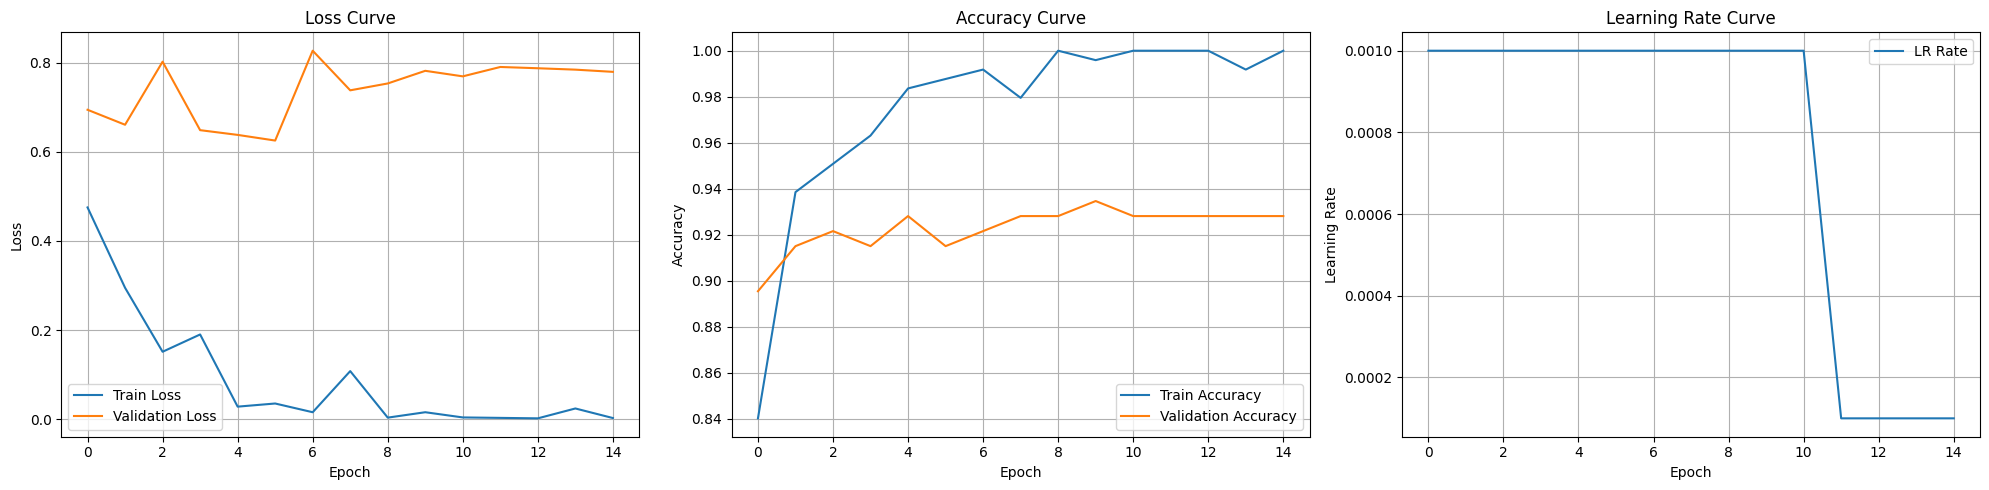

In [78]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=15,
    opt=opt,
    loss_model=loss_model,
    lr_scheduler=lr_scheduler
)

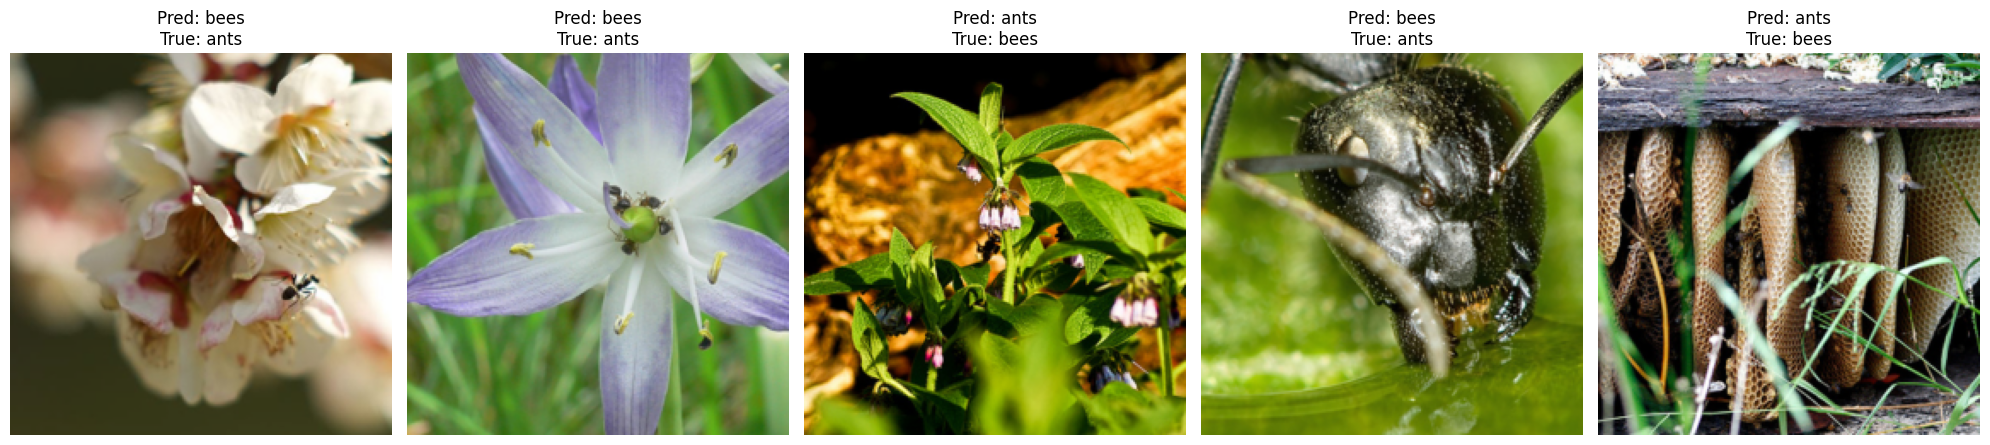

In [ ]:
# Переведём модель в режим оценки
model.eval()

errors = []
images_shown = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        # Накапливаем ошибки
        for img, pred, label in zip(inputs.cpu(), preds.cpu(), labels.cpu()):
            if pred != label:
                errors.append((img, pred.item(), label.item()))
        if len(errors) > 100:  # достаточно насобирать 100 ошибок, чтобы для rnd выбрать 5, потом выйдем
            break

# Случайно выбираем 5 ошибочных
to_show = random.sample(errors, min(5, len(errors)))

plt.figure(figsize=(20, 5))
for i, (img, pred, label) in enumerate(to_show):
    plt.subplot(1, 5, i+1)
    # denormalize, если применялся normalization в трансформе
    img = img.permute(1, 2, 0).numpy()
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f"Pred: {class_names[pred]}\nTrue: {class_names[label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

**Выводы**:

Комментарии излишни, результаты на ваших экранах, господа.
1. 15 эпох обучения за **8 минут**
2. **92% точности** на валидации (перегрели модельку, на графике четко видно переобучение - необходим более умный *lr_scheduler*)

***Transfer Learning*** - отличный подход, который помогает за минимальное время и ресурсы получить хорошие показатели точности.